<a href="https://colab.research.google.com/github/sudarshanmungi39/Generative-modelling-case-study-Cyber-Security-/blob/main/research_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import numpy as np

# Set seed for reproducibility
torch.manual_seed(42);

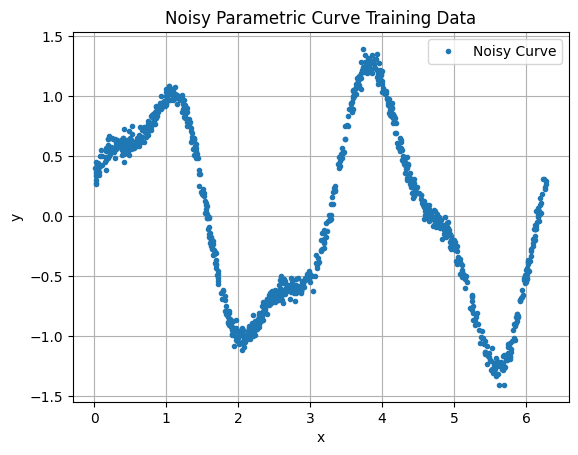

In [2]:
# Create 2D data for the noisy parametric curve
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))

# Generate random x values in [0, 2π]
train_data[:, 0] = 2.0 * math.pi * torch.rand(train_data_length)

# Compute y = sin(2x) + 0.3cos(5x) + noise
noise = 0.05 * torch.randn(train_data_length)
train_data[:, 1] = torch.sin(2 * train_data[:, 0]) + 0.3 * torch.cos(5 * train_data[:, 0]) + noise

# Dummy labels (not used in GAN)
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Plot to verify
plt.plot(train_data[:, 0], train_data[:, 1], ".", label="Noisy Curve")
plt.title("Noisy Parametric Curve Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator()

In [4]:
# Define the Generator

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

generator = Generator()

In [5]:
# Set Up Training Config
lr = 0.001
num_epochs = 3000  # 🔼 Increased for better convergence
loss_function = nn.BCELoss()

optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr)

In [6]:
# GAN Training Loop

losses_g = []
losses_d = []

for epoch in range(num_epochs):
    for real_samples, _ in train_loader:
        real_samples = real_samples.float()

        # === Train Discriminator ===
        real_labels = torch.ones((real_samples.size(0), 1))
        fake_labels = torch.zeros((real_samples.size(0), 1))

        # Generate fake samples
        latent_space_samples = torch.randn(real_samples.size(0), 2)
        generated_samples = generator(latent_space_samples)

        # Combine real and fake
        all_samples = torch.cat((real_samples, generated_samples), dim=0)
        all_labels = torch.cat((real_labels, fake_labels), dim=0)

        # Train discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_d = loss_function(output_discriminator, all_labels)
        loss_d.backward()
        optimizer_discriminator.step()

        # === Train Generator ===
        generator.zero_grad()
        latent_space_samples = torch.randn(real_samples.size(0), 2)
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)

        loss_g = loss_function(output_discriminator_generated, real_labels)
        loss_g.backward()
        optimizer_generator.step()

    # Save losses for plotting
    losses_d.append(loss_d.item())
    losses_g.append(loss_g.item())

    # Print every 500 epochs for feedback
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss D = {loss_d.item():.4f} | Loss G = {loss_g.item():.4f}")

Epoch 0: Loss D = 0.1695 | Loss G = 2.0631
Epoch 500: Loss D = 0.6949 | Loss G = 0.7415
Epoch 1000: Loss D = 0.6904 | Loss G = 0.7182
Epoch 1500: Loss D = 0.7092 | Loss G = 0.7007
Epoch 2000: Loss D = 0.6909 | Loss G = 0.7087
Epoch 2500: Loss D = 0.6974 | Loss G = 0.7011


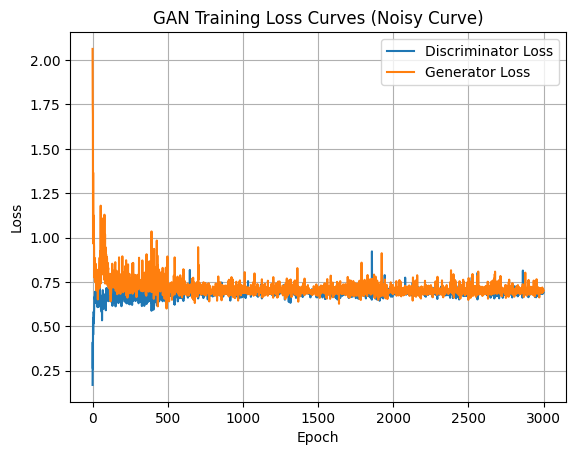

In [7]:
# Plot Training Losses

plt.plot(losses_d, label="Discriminator Loss")
plt.plot(losses_g, label="Generator Loss")
plt.title("GAN Training Loss Curves (Noisy Curve)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

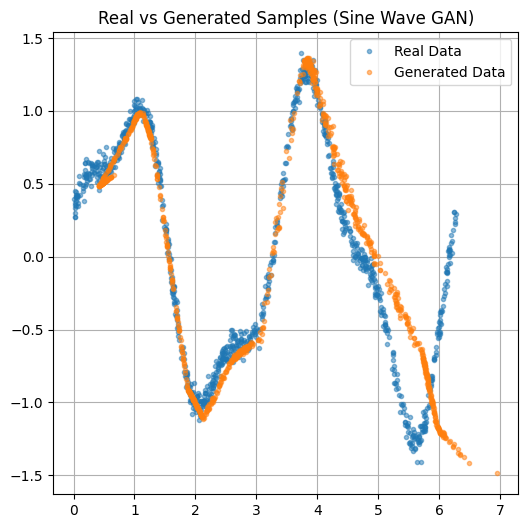

In [8]:
# Generate and Plot Fake Data

# Generate new samples from the generator
latent_samples = torch.randn(1000, 2)
generated = generator(latent_samples).detach().numpy()

plt.figure(figsize=(6, 6))
plt.plot(train_data[:, 0], train_data[:, 1], ".", label="Real Data", alpha=0.5)
plt.plot(generated[:, 0], generated[:, 1], ".", label="Generated Data", alpha=0.5)
plt.title("Real vs Generated Samples (Sine Wave GAN)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a deeper MLP generator using LeakyReLU
        self.model = nn.Sequential(
            nn.Linear(2, 64),           # Input layer: from 2D latent space to 64 neurons
            nn.LeakyReLU(0.2),          # LeakyReLU helps avoid dead neurons
            nn.Linear(64, 128),         # Hidden layer: deeper architecture improves expressiveness
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),         # Hidden layer: added depth allows better function approximation
            nn.LeakyReLU(0.2),
            nn.Linear(64, 2)            # Output layer: generates 2D points
        )

    def forward(self, x):
        return self.model(x)  # Forward pass through the generator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # A slightly shallower discriminator using LeakyReLU and dropout for regularization
        self.model = nn.Sequential(
            nn.Linear(2, 64),           # Input layer: accepts 2D samples
            nn.LeakyReLU(0.2),          # LeakyReLU improves gradient flow
            nn.Dropout(0.3),            # Dropout prevents overfitting
            nn.Linear(64, 32),          # Reduced complexity to balance generator
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(32, 1),           # Output layer: single value (real/fake probability)
            nn.Sigmoid()                # Sigmoid activation to squash output to [0, 1]
        )

    def forward(self, x):
        return self.model(x)  # Forward pass through the discriminator

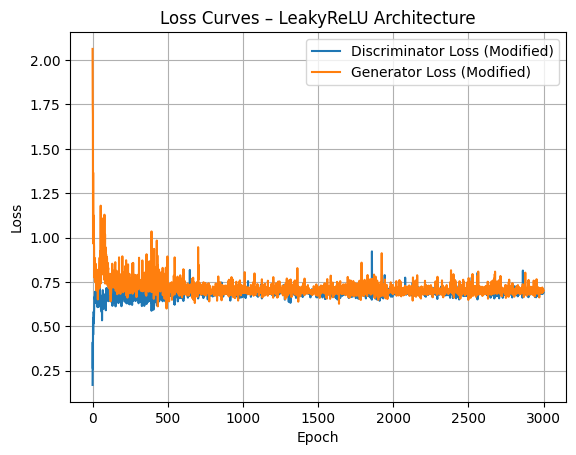

In [11]:
plt.plot(losses_d, label="Discriminator Loss (Modified)")
plt.plot(losses_g, label="Generator Loss (Modified)")
plt.title("Loss Curves – LeakyReLU Architecture")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

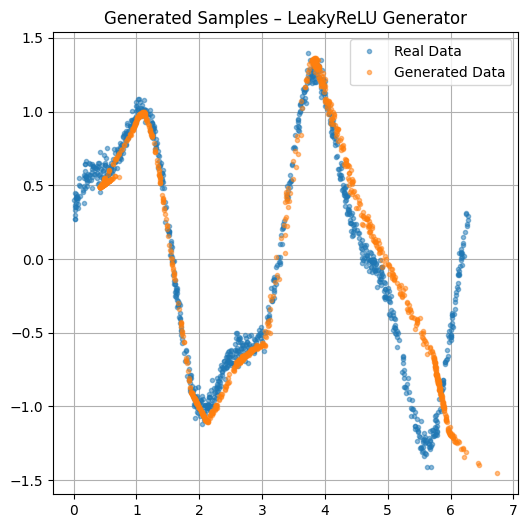

In [12]:
latent_samples = torch.randn(1000, 2)
generated = generator(latent_samples).detach().numpy()

plt.figure(figsize=(6, 6))
plt.plot(train_data[:, 0], train_data[:, 1], ".", label="Real Data", alpha=0.5)
plt.plot(generated[:, 0], generated[:, 1], ".", label="Generated Data", alpha=0.5)
plt.title("Generated Samples – LeakyReLU Generator")
plt.legend()
plt.grid(True)
plt.show()